# STABLE DIFFUSION MODEL - OPTIMIZED

Installing the necessary python packages:

In [1]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00


Importing the required files:

In [2]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login

device = 'cuda'
notebook_login()

#We have to import our Hugging face access token.

Importing our pre-trained model:

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

The pre-trained model generates us an image based on the prompt we give it.

0it [00:00, ?it/s]

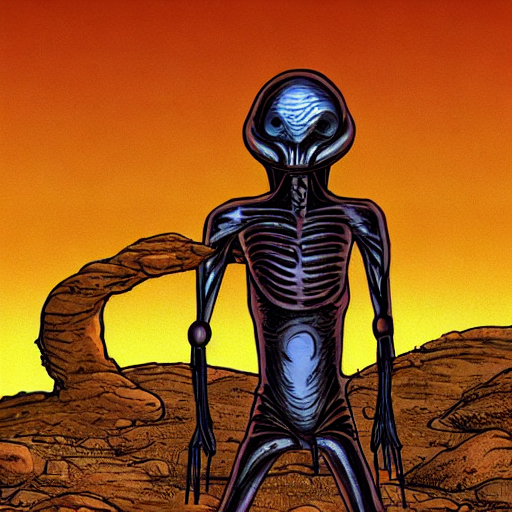

In [4]:
prompt = 'an alien on mars sci-fi style'
with autocast(device):
  image = pipe(prompt)['sample'][0]
image

Making a sample of three images per prompt.

In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The function above takes a list of images, and creates a grid of those images using the PIL library, where the number of rows and columns of the grid is specified as input arguments.

The code below generates images based on text prompts and then displays the generated images in a grid format. We use the "autocast" function from torch library to set the device to be used as "cuda".

0it [00:00, ?it/s]

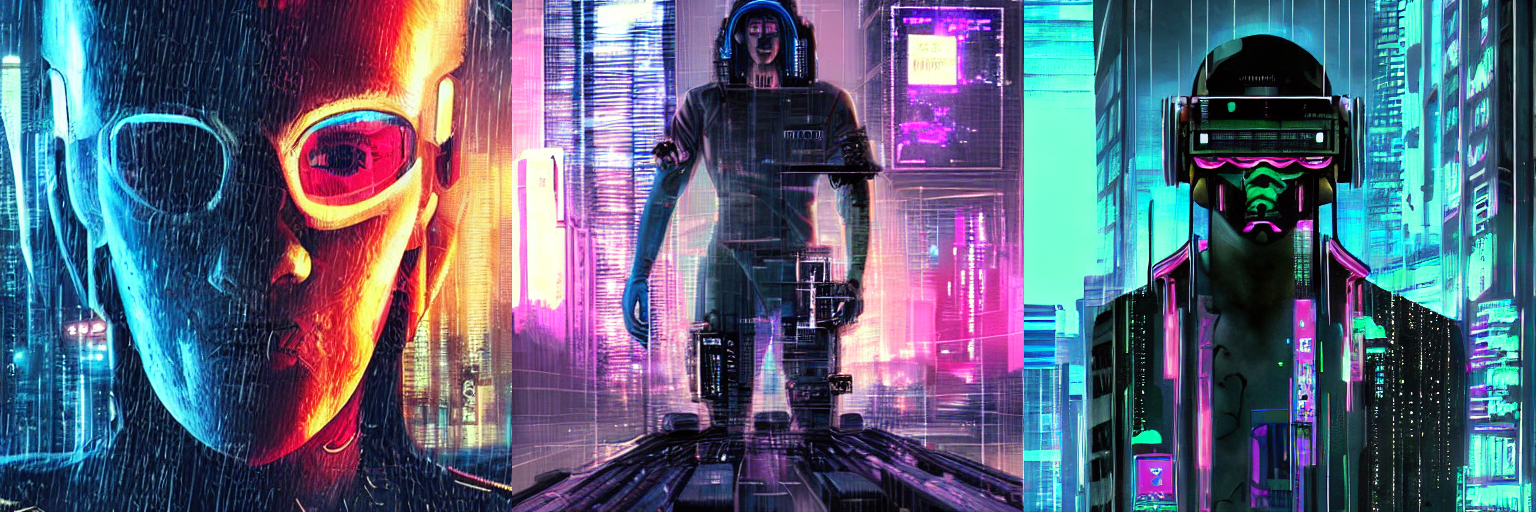

In [6]:
n_images = 3
prompts = ['Cyberpunk style art'] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50)['sample']
image_grid(images, rows=1, cols=3)

Now we want to optimize this model with our own pipeline. First we need to import the Autoencoder and U-NET models:

In [7]:
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)
#we load a pre-trained VAE model from the Hugging Face model hub and move it to
#the specified device (cuda in our example).

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [8]:
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)
# we load a pre-trained U-NET model from the Hugging Face model hub and move it to
#the specified device (cuda in our example).

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Using Autoencoder and U-NET models we would be able to replace the above functions with a new function that utilizes these models.

Autoencoder models can be used to compress the input images and extract a lower-dimensional representation of them, which can be used to generate new images. This can be useful to reduce the computational cost of generating images.

U-NET models are a type of convolutional neural network (CNN) that can be used for image segmentation tasks. They can be used to generate high-quality images by using features from different levels of the network.

Importing tokenizer and text encoder:

In [9]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)
# we load a pre-trained tokenizer and text encoder from the Hugging Face model hub.
#The pre-trained tokenizer is responsible for which is responsible for tokenizing the
#input texts, that is, splitting it into words, subwords or characters, depending on the tokenizer's settings.

#The text encoder is responsible for encoding input text into a representation that can
#be used by a machine learning model.

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.mlp.fc1.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.21.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.12.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.mlp.fc1.weight', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.16.mlp.fc1.weight', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.we

Importing scheduler:

In [11]:
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

The code above creates an instance of a scheduler using the LMSDiscreteScheduler class from the diffusers library and it's responsible for controlling the amount of noise that is added to the input during training in a discrete time steps during the training process.

Functions for text embedding, getting latent and returning the decoded image:

In [12]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

The function above takes a string as input and tokenizes it, then it encodes the tokenized input to get the text embeddings and unconditional embeddings, it then concatenates the two embeddings and returns the result as a single tensor. It uses the tokenizer and text encoder we created earlier.

In [14]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']
  
  return latents

The function above is used to produce the latents, which are the random values used as the starting point for generating images. The function takes the text embeddings, and additional parameters such as height, width, number of inference steps, guidance scale, and latents. The function uses the U-Net model to predict the noise residual, then performs guidance and computes the previous noisy sample.

In [15]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

The function above takes in a tensor of latents, which are the compressed representations of images, and uses the VAE (AutoencoderKL) model to decode them into images. The latents are first scaled by a factor of 1/0.18215. Then, the VAE's decode method is used to generate images from the latents. The resulting images are then scaled to be between 0 and 1, and then converted to an 8-bit integer format. Finally, the images are transformed into PIL images using the Image module from the Python Imaging Library (PIL) and returned as a list of PIL images.






In [16]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
  
  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

The above function takes as input a list of prompts and a set of optional parameters such as image height and width, number of inference steps, guidance scale and latents. The function first converts the prompts into text embeddings using the get_text_embeds function. Then, it uses these text embeddings and the optional latents to produce image latents using the produce_latents function. Finally, it decodes the image latents into images using the decode_img_latents function, which applies the trained Variational Autoencoder to the latents and returns the decoded images in the form of a list of PIL (Python Imaging Library) images.

Generating a few images with our fine-tuned model:

0it [00:00, ?it/s]

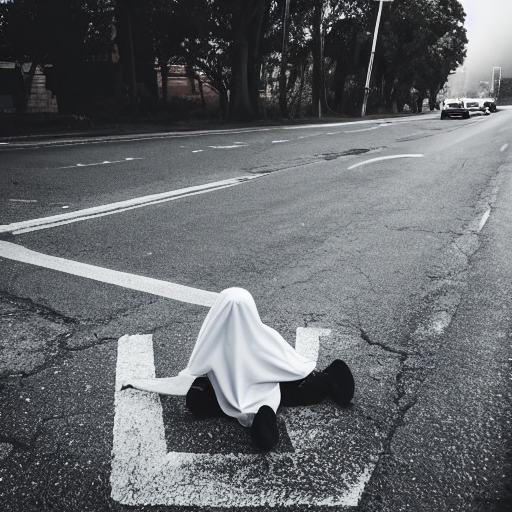

In [17]:
prompt_to_img('ghost in the middle of the road', 512, 512, 20)[0]

0it [00:00, ?it/s]

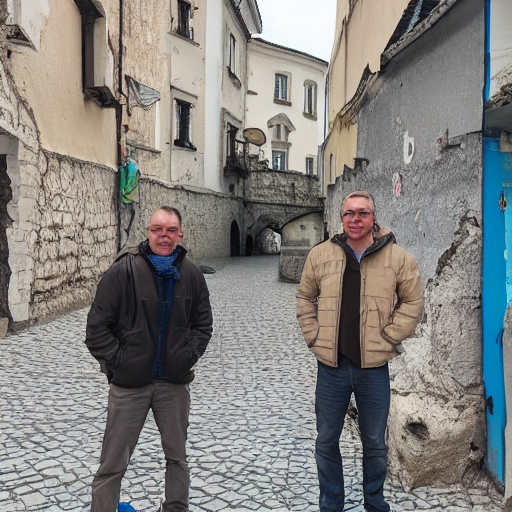

In [18]:
prompt_to_img('two guys visiting Eastern Europe', 512, 512, 20)[0]

# In Summary:

In this notebook we use pre-trained models such as UNet and Autoencoder and fine-tune them to optimize the performance on generating images. This is done by using the pre-trained models as starting points and then training them while keeping some of the weights of the pre-trained model fixed. We also use a scheduler, which is a LMSDiscreteScheduler, to control the training process. Additionally, We use a tokenizer and text encoder, which are CLIPTokenizer and CLIPTextModel, to convert the prompts into text embeddings. The function prompt_to_img() takes in a prompt and converts it into an image by passing it through the text encoder, producing latents from text embeddings, and then passing the latents to the decoder of the autoencoder to generate the image. The final code is a pipeline that takes a prompt and generates an image from it.